In [1]:
import beatfinder
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
totensor = beatfinder.model.ToTensor(device)
print(f'Device: {device}')

Device: cuda


# Save datasets

In [3]:
# BALLROOM dataset

# Make a validation dataset
audio_files   = './data/BALLROOM/valid_audio_files.txt'
where_to_save = './data/saved-datasets/ballroom/valid/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Make a training dataset
audio_files   = './data/BALLROOM/train_audio_files.txt'

# no augmentation
where_to_save = './data/saved-datasets/ballroom/train/normal'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# first augmented
where_to_save = './data/saved-datasets/ballroom/train/augmented_1'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# second augmented
where_to_save = './data/saved-datasets/ballroom/train/augmented_2'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# third augmented
audio_files   = './data/BALLROOM/train_audio_files.txt'
where_to_save = './data/saved-datasets/ballroom/train/augmented_3'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

In [4]:
# GTZAN dataset

# Make a validation dataset
audio_files   = './data/GTZAN/valid_audio_files.txt'
where_to_save = './data/saved-datasets/gtzan/valid/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Make a training dataset
audio_files   = './data/GTZAN/train_audio_files.txt'

# no augmentation
where_to_save = './data/saved-datasets/gtzan/train/normal/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# first augmented
where_to_save = './data/saved-datasets/gtzan/train/augmented_1/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# second augmented
where_to_save = './data/saved-datasets/gtzan/train/augmented_2/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save, force_nb_samples=3)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

In [3]:
# HAINSWORTH dataset

# Make a validation dataset
audio_files   = './data/HAINSWORTH/valid_audio_files.txt'
where_to_save = './data/saved-datasets/hainsworth/valid/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Make a training dataset
audio_files   = './data/HAINSWORTH/train_audio_files.txt'

# no augmentation
where_to_save = './data/saved-datasets/hainsworth/train/normal/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save)
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# first augmented
where_to_save = './data/saved-datasets/hainsworth/train/augmented_1/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# second augmented
where_to_save = './data/saved-datasets/hainsworth/train/augmented_2/'
dataset = beatfinder.datasets.AudioBeatsDatasetFromList(
            audio_files, where_to_save)
dataset.augment()
dataset.save(os.path.join(where_to_save, 'dataset.ab'))

# Make trainset and validset

In [4]:
ballroom_validset      = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/ballroom/valid/dataset.ab')
ballroom_trainset_norm = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/ballroom/train/normal/dataset.ab')
ballroom_trainset_aug1 = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/ballroom/train/augmented_1/dataset.ab')
ballroom_trainset_aug2 = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/ballroom/train/augmented_2/dataset.ab')
ballroom_trainset      = ballroom_trainset_norm + ballroom_trainset_aug1 + ballroom_trainset_aug2

In [5]:
gtzan_validset      = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/gtzan/valid/dataset.ab')
gtzan_trainset_norm = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/gtzan/train/normal/dataset.ab')
gtzan_trainset_aug1 = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/gtzan/train/augmented_1/dataset.ab')
gtzan_trainset_aug2 = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/gtzan/train/augmented_2/dataset.ab')
gtzan_trainset      = gtzan_trainset_norm + gtzan_trainset_aug1 + gtzan_trainset_aug2
gtzan               = gtzan_validset + gtzan_trainset

In [6]:
hainsworth_validset      = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/hainsworth/valid/dataset.ab')
hainsworth_trainset_norm = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/hainsworth/train/normal/dataset.ab')
hainsworth_trainset_aug1 = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/hainsworth/train/augmented_1/dataset.ab')
hainsworth_trainset_aug2 = beatfinder.datasets.AudioBeatsDataset(
                                file='./data/saved-datasets/hainsworth/train/augmented_2/dataset.ab')
hainsworth_trainset      = hainsworth_trainset_norm + hainsworth_trainset_aug1 + hainsworth_trainset_aug2
hainsworth               = hainsworth_validset + hainsworth_trainset

In [22]:
trainset = ballroom_trainset + gtzan + hainsworth
validset = ballroom_validset

In [26]:
print(f'trainset size: {len(trainset)}')
print(f'validset size: {len(validset)}')

trainset size: 13124
validset size: 420


In [27]:
trainset.save('./data/saved-datasets/tmp/trainset.ab')
validset.save('./data/saved-datasets/tmp/validset.ab')

In [ ]:
trainset.clean()
trainset.save('./data/saved-datasets/tmp/trainset-cleaned.ab')

# Make corrected trainset

In [2]:
trainset = beatfinder.datasets.AudioBeatsDataset(file='./data/saved-datasets/tmp/trainset.ab')

In [3]:
onsets_path = './data/saved-datasets/tmp/corrected-trainset-onsets/'
for i, audiobeats in enumerate(trainset):
    audiobeats.onsets_file = os.path.join(onsets_path, f'corrected_onsets_{i:05d}.csv')

In [4]:
trainset.precompute(mode='onsets_and_isbeat')

In [5]:
trainset.correct()

In [6]:
trainset.clean()

In [7]:
trainset.save('./data/saved-datasets/tmp/trainset-corrected-cleaned.ab')

In [8]:
print(f'corrected and cleaned trainset size: {len(trainset)}')

corrected and cleaned trainset size: 12255


# Load datasets

In [2]:
trainset = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/tmp/trainset-cleaned.ab')
validset = beatfinder.datasets.AudioBeatsDataset(
                            file='./data/saved-datasets/tmp/validset.ab')

In [3]:
print(f'trainset size: {len(trainset)}')
print(f'validset size: {len(validset)}')

trainset size: 12339
validset size: 420


# Check examples

In [4]:
dataset = trainset

8692/12255
         Name: Media-106105.000
Song duration: 24.78
      Stretch: 0.7796
       Offset: 12.6069


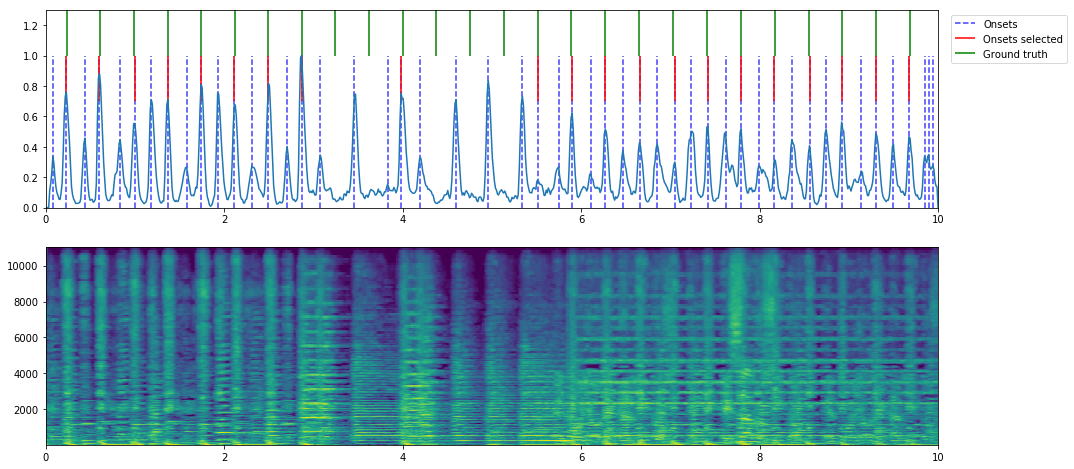

In [15]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
audiobeats = dataset[i]
print(f'         Name: {audiobeats.name}')
print(f'Song duration: {audiobeats.song_duration:.2f}')
print(f'      Stretch: {audiobeats.stretch:.4f}')
print(f'       Offset: {audiobeats.offset:.4f}')
beatfinder.display.showdata(audiobeats)

F measure: 1.00


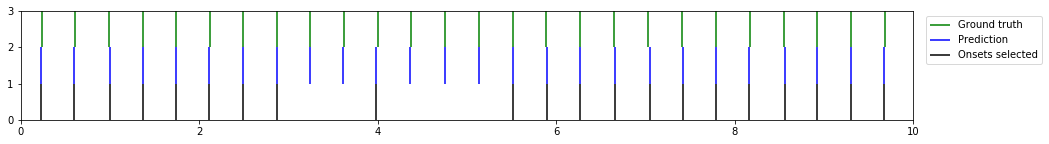

In [16]:
spec, onsets, isbeat, beats = audiobeats.get_data()
onsets_selected = beatfinder.utils.onsets_selected(onsets, isbeat)
pred_beats, bpm = beatfinder.utils.beat_track(onsets_selected, 300)
beatfinder.display.showprediction(beats, pred_beats, onsets_selected)
print(f'F measure: {beatfinder.utils.F_measure(beats, pred_beats):.2f}')

# Setup datasets for pytorch

In [17]:
totensor = beatfinder.model.ToTensor(device)
trainset.transform = totensor
validset.transform = totensor

# Find learning rate

In [18]:
model = beatfinder.model.BeatFinder()
model.to(device)

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

In [19]:
dataloader = DataLoader(trainset, batch_size=128, shuffle=True)
n_mb = len(dataloader) # number of mini batches
print(f'{n_mb} mini batches')
lr = (10. ** -np.arange(1, 5, 4 / n_mb))[::-1]
print(f'{len(lr)} learning rates')

96 mini batches
96 learning rates


In [20]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    model.set_lr(lr[i])
    tn, fp, fn, tp, loss = model.learn(specs, onsets, isbeat)
    losses[i] = loss
    print(f'{i + 1}/{n_mb}', end='\r')

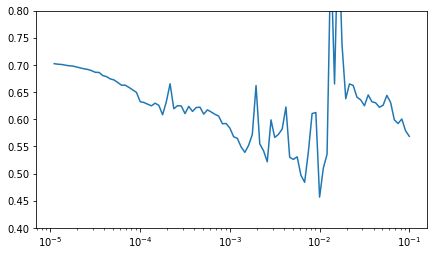

In [21]:
plt.figure(figsize=(7, 4))
plt.ylim(0.4, 0.8)
plt.semilogx(lr, losses);

# Train

In [22]:
model = beatfinder.model.BeatFinder(lr=0.001)
model.to(device)
print(model)
model.eval()
model.freeze()

BeatFinder(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)


In [23]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------------
| tp:  5156 | fp: 10968 |
| fn:  3342 | tn:  4196 |
 -----------------------
 Accuracy: 0.3952
Precision: 0.3198
   Recall: 0.6067
F-measure: 0.4188
     Loss: 0.6952


In [24]:
model.unfreeze()
model.train();

In [25]:
train_hist1, valid_hist1 = model.fit(trainset, validset, batch_size=128, epochs=20, early_stop=0.25)

|  1 | L: 0.448 0.386 | F: 0.652 0.762 | A: 0.789 0.834 | 1.95 s/b | 0:03:07 | ETA: 0:59:19 |
|  2 | L: 0.345 0.337 | F: 0.773 0.792 | A: 0.852 0.856 | 1.94 s/b | 0:03:06 | ETA: 0:55:53 |
|  3 | L: 0.334 0.371 | F: 0.783 0.768 | A: 0.858 0.839 | 1.96 s/b | 0:03:08 | ETA: 0:53:26 |
|  4 | L: 0.313 0.373 | F: 0.800 0.772 | A: 0.869 0.838 | 1.99 s/b | 0:03:11 | ETA: 0:50:58 |
|  5 | L: 0.335 0.426 | F: 0.781 0.719 | A: 0.858 0.816 | 1.94 s/b | 0:03:06 | ETA: 0:46:36 |


KeyboardInterrupt: 

In [35]:
train_hist2, valid_hist2 = model.fit(trainset, validset, batch_size=128, epochs=5)

| 1 | L: 0.268 0.291 | F: 0.828 0.831 | A: 0.889 0.881 | 1.78 s/b | 0:02:52 | ETA: 0:11:29 |
| 2 | L: 0.275 0.312 | F: 0.823 0.818 | A: 0.887 0.874 | 1.78 s/b | 0:02:52 | ETA: 0:08:36 |
| 3 | L: 0.302 0.317 | F: 0.802 0.813 | A: 0.874 0.867 | 1.76 s/b | 0:02:51 | ETA: 0:05:42 |
| 4 | L: 0.271 0.320 | F: 0.828 0.805 | A: 0.890 0.867 | 1.78 s/b | 0:02:52 | ETA: 0:02:52 |
| 5 | L: 0.247 0.352 | F: 0.845 0.783 | A: 0.900 0.851 | 1.76 s/b | 0:02:50 | ETA: 0:00:00 |


In [12]:
torch.save(model.state_dict(), './data/pretrained-models/model_11.pt')

In [31]:
np.save('./data/pretrained-models/model_11_train_hist.npy', train_hist1)
np.save('./data/pretrained-models/model_11_valid_hist.npy', valid_hist1)

In [13]:
model.eval()
model.freeze()

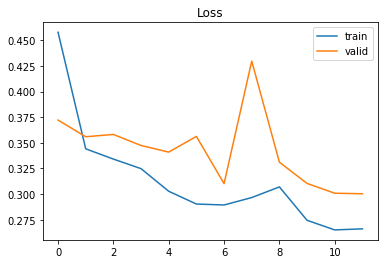

In [16]:
# optim.Adam(self.parameters(), lr=0.001, eps=1e-6, weight_decay=1e-5, amsgrad=True)
# Early stopping at epoch 13, minibatch 20

plt.plot(np.mean(train_hist1[:12, :, 4], axis=1), label='train')
plt.plot(valid_hist1[:12, 4], label='valid')
plt.title('Loss')
plt.legend();

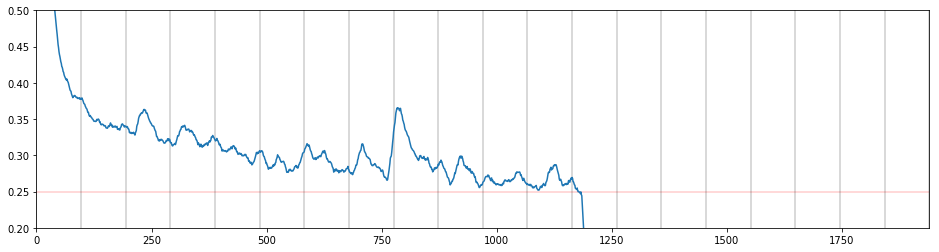

In [18]:
loss_hist1 = np.reshape(train_hist1, (20 * 97, 5))[:, 4]
a = 20
avg_loss_hist1 = np.array([loss_hist1[i - a: i].mean() for i in range(a, len(loss_hist1))])
plt.figure(figsize=(16, 4))
plt.ylim(0.2, 0.5)
plt.xlim(0, len(loss_hist1))
plt.plot(np.arange(a, len(loss_hist1)), avg_loss_hist1)
plt.hlines(0.25, 0, len(loss_hist1), alpha=0.2, color='r')
plt.vlines(np.arange(21) * 97, 0.2, 0.5, alpha=0.2);

In [21]:
a_train = np.zeros(12)
F_train = np.zeros(12)
a_valid = np.zeros(12)
F_valid = np.zeros(12)

for e in range(12):
    tn = np.sum(train_hist1[e, :, 0])
    fp = np.sum(train_hist1[e, :, 1])
    fn = np.sum(train_hist1[e, :, 2])
    tp = np.sum(train_hist1[e, :, 3])
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    a_train[e] = a
    F_train[e] = F
    
    tn = valid_hist1[e, 0]
    fp = valid_hist1[e, 1]
    fn = valid_hist1[e, 2]
    tp = valid_hist1[e, 3]
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    
    a_valid[e] = a
    F_valid[e] = F

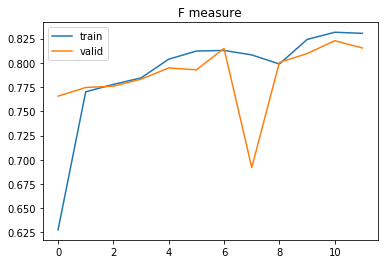

In [22]:
plt.plot(F_train, label='train')
plt.plot(F_valid, label='valid')
plt.title('F measure')
plt.legend();

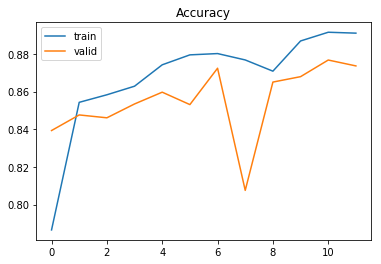

In [23]:
plt.plot(a_train, label='train')
plt.plot(a_valid, label='valid')
plt.title('Accuracy')
plt.legend();

In [24]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------------
| tp:  6623 | fp:  1040 |
| fn:  1875 | tn: 14124 |
 -----------------------
 Accuracy: 0.8768
Precision: 0.8643
   Recall: 0.7794
F-measure: 0.8196
     Loss: 0.2985


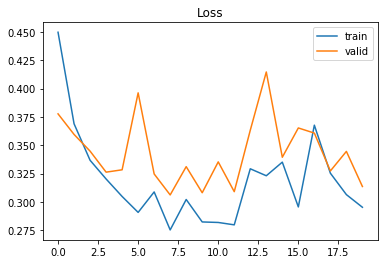

In [13]:
# 0-20, optim.Adam(self.parameters(), lr=0.001, eps=1e-6, weight_decay=1e-5, amsgrad=True)
plt.plot(np.mean(train_hist1[:, :, 4], axis=1), label='train')
plt.plot(valid_hist1[:, 4], label='valid')
plt.title('Loss')
plt.legend();

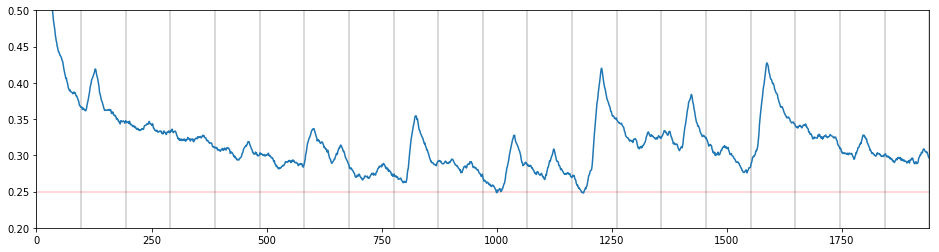

In [68]:
loss_hist1 = np.reshape(train_hist1, (20 * 97, 5))[:, 4]
a = 20
avg_loss_hist1 = np.array([loss_hist1[i - a: i].mean() for i in range(a, len(loss_hist1))])
plt.figure(figsize=(16, 4))
plt.ylim(0.2, 0.5)
plt.xlim(0, len(loss_hist1))
plt.plot(np.arange(a, len(loss_hist1)), avg_loss_hist1)
plt.hlines(0.25, 0, len(loss_hist1), alpha=0.2, color='r')
plt.vlines(np.arange(21) * 97, 0.2, 0.5, alpha=0.2);

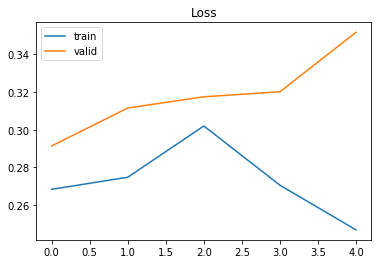

In [59]:
# 20-25. optim.Adam(self.parameters(), lr=0.001, eps=1e-6, weight_decay=1e-5, amsgrad=True)
plt.plot(np.mean(train_hist2[:, :, 4], axis=1), label='train')
plt.plot(valid_hist2[:, 4], label='valid')
plt.title('Loss')
plt.legend();

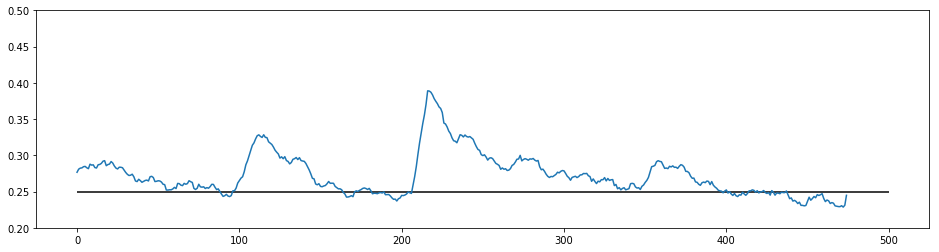

In [66]:
loss_hist2 = np.reshape(train_hist2, (5 * 97, 5))[:, 4]
avg_loss_hist2 = np.array([loss_hist2[i:i+10].mean() for i in range(len(loss_hist2) - 10)])
plt.figure(figsize=(16, 4))
plt.plot(avg_loss_hist2)
plt.hlines(0.25, 0, 500)
plt.ylim(0.2, 0.5);

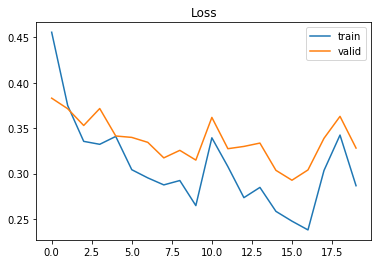

In [37]:
# optim.Adam(self.parameters(), lr=0.001, eps=1e-6, weight_decay=1e-5, amsgrad=True)
plt.plot(np.mean(train_hist1[:, :, 4], axis=1), label='train')
plt.plot(valid_hist1[:, 4], label='valid')
plt.title('Loss')
plt.legend();

In [57]:
loss_hist1 = np.reshape(train_hist1, (20 * 97, 5))[:, 4]
avg_loss_hist1 = np.array([loss_hist1[i:i+30].mean() for i in range(len(loss_hist1) - 30)])

(0.2, 0.5)

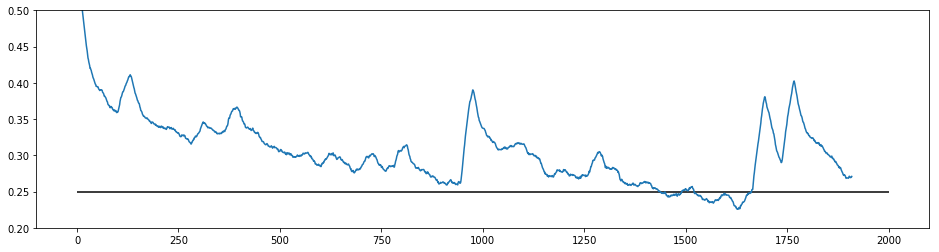

In [58]:
plt.figure(figsize=(16, 4))
plt.plot(avg_loss_hist1)
plt.hlines(0.25, 0, 2000)
plt.ylim(0.2, 0.5)

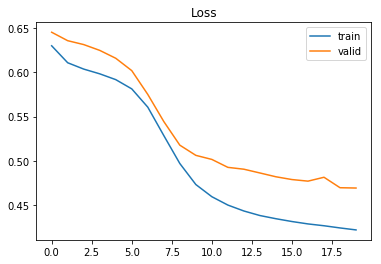

In [26]:
# SGD cleaned lr=0.009
plt.plot(np.mean(train_hist1[:, :, 4], axis=1), label='train')
plt.plot(valid_hist1[:, 4], label='valid')
plt.title('Loss')
plt.legend();

(0.2, 0.6)

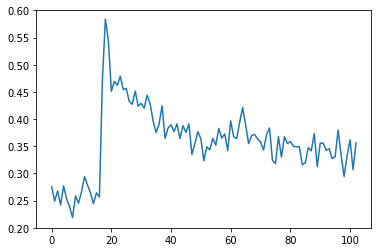

In [36]:
plt.plot(train_hist1[9, :, 4])
plt.ylim(0.2, 0.6)

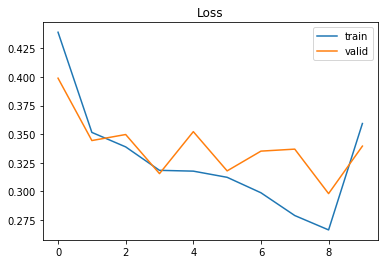

In [17]:
plt.plot(np.mean(train_hist1[:, :, 4], axis=1), label='train')
plt.plot(valid_hist1[:, 4], label='valid')
plt.title('Loss')
plt.legend();

In [25]:
a_train = np.zeros(5)
F_train = np.zeros(5)
a_valid = np.zeros(5)
F_valid = np.zeros(5)

for e in range(5):
    tn = np.sum(train_hist2[e, :, 0])
    fp = np.sum(train_hist2[e, :, 1])
    fn = np.sum(train_hist2[e, :, 2])
    tp = np.sum(train_hist2[e, :, 3])
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    a_train[e] = a
    F_train[e] = F
    
    tn = valid_hist2[e, 0]
    fp = valid_hist2[e, 1]
    fn = valid_hist2[e, 2]
    tp = valid_hist2[e, 3]
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    
    a_valid[e] = a
    F_valid[e] = F

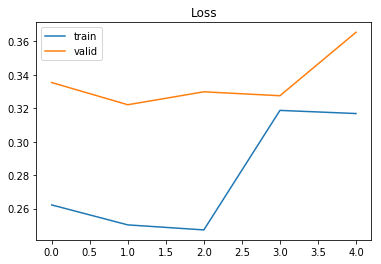

In [26]:
plt.plot(np.mean(train_hist2[:, :, 4], axis=1), label='train')
plt.plot(valid_hist2[:, 4], label='valid')
plt.title('Loss')
plt.legend();

In [14]:
a_train = np.zeros(10)
F_train = np.zeros(10)
a_valid = np.zeros(10)
F_valid = np.zeros(10)

for e in range(10):
    tn = np.sum(train_hist1[e, :, 0])
    fp = np.sum(train_hist1[e, :, 1])
    fn = np.sum(train_hist1[e, :, 2])
    tp = np.sum(train_hist1[e, :, 3])
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    a_train[e] = a
    F_train[e] = F
    
    tn = valid_hist1[e, 0]
    fp = valid_hist1[e, 1]
    fn = valid_hist1[e, 2]
    tp = valid_hist1[e, 3]
    a, p, r, F = beatfinder.utils.measures(tn, fp, fn, tp)
    
    a_valid[e] = a
    F_valid[e] = F

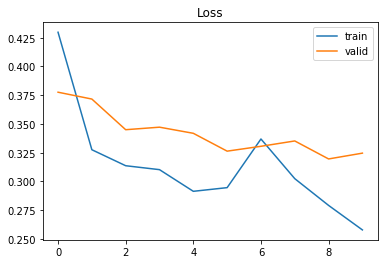

In [16]:
plt.plot(np.mean(train_hist1[:, :, 4], axis=1), label='train')
plt.plot(valid_hist1[:, 4], label='valid')
plt.title('Loss')
plt.legend();

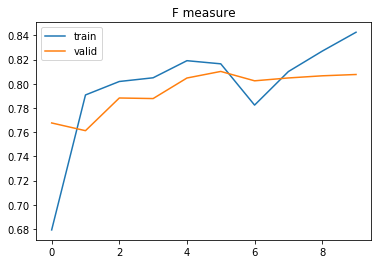

In [17]:
plt.plot(F_train, label='train')
plt.plot(F_valid, label='valid')
plt.title('F measure')
plt.legend();

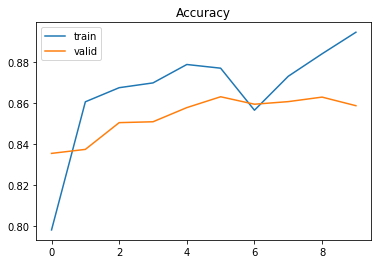

In [18]:
plt.plot(a_train, label='train')
plt.plot(a_valid, label='valid')
plt.title('Accuracy')
plt.legend();

In [19]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------------
| tp:  7024 | fp:  1863 |
| fn:  1474 | tn: 13301 |
 -----------------------
 Accuracy: 0.8590
Precision: 0.7904
   Recall: 0.8265
F-measure: 0.8081
     Loss: 0.3228


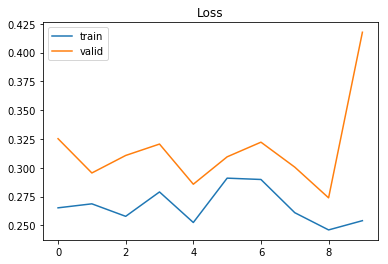

In [49]:
plt.plot(np.mean(train_hist1[:, :, 4], axis=1), label='train')
plt.plot(valid_hist1[:, 4], label='valid')
plt.title('Loss')
plt.legend();

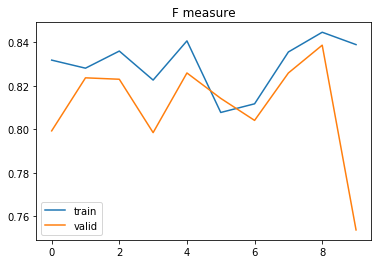

In [50]:
plt.plot(F_train, label='train')
plt.plot(F_valid, label='valid')
plt.title('F measure')
plt.legend();

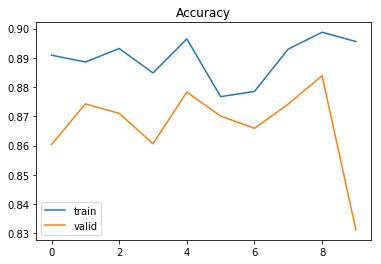

In [51]:
plt.plot(a_train, label='train')
plt.plot(a_valid, label='valid')
plt.title('Accuracy')
plt.legend();

In [52]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------------
| tp:  6198 | fp:  1629 |
| fn:  2300 | tn: 13535 |
 -----------------------
 Accuracy: 0.8340
Precision: 0.7919
   Recall: 0.7293
F-measure: 0.7593
     Loss: 0.4143


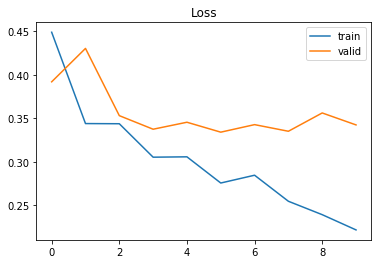

In [18]:
plt.plot(np.mean(train_hist[:, :, 4], axis=1), label='train')
plt.plot(valid_hist[:, 4], label='valid')
plt.title('Loss')
plt.legend();

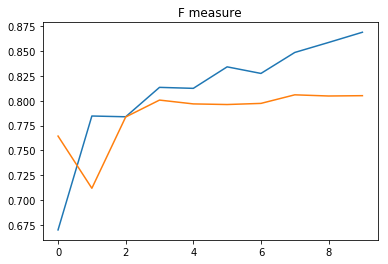

In [21]:
plt.plot(F_train, label='train')
plt.plot(F_valid, label='valid')
plt.title('F measure')
plt.legend();

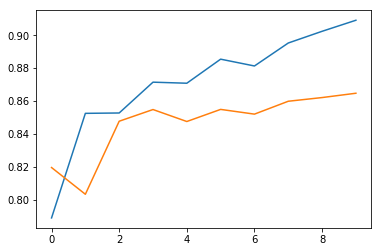

In [22]:
plt.plot(a_train, label='train')
plt.plot(a_valid, label='valid')
plt.title('Accuracy')
plt.legend();

In [23]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
beatfinder.display.confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------------
| tp:  6617 | fp:  1313 |
| fn:  1881 | tn: 13851 |
 -----------------------
 Accuracy: 0.8650
Precision: 0.8344
   Recall: 0.7787
F-measure: 0.8056
     Loss: 0.3509


# Import saved model

In [4]:
model = beatfinder.model.BeatFinder()
model.load_state_dict(torch.load('./data/pretrained-models/model_11.pt', map_location=device))
model.to(device)
model.eval()
model.freeze()

# Look at an example of a prediction

In [5]:
dataset = validset
dataset.transform = None

354/420


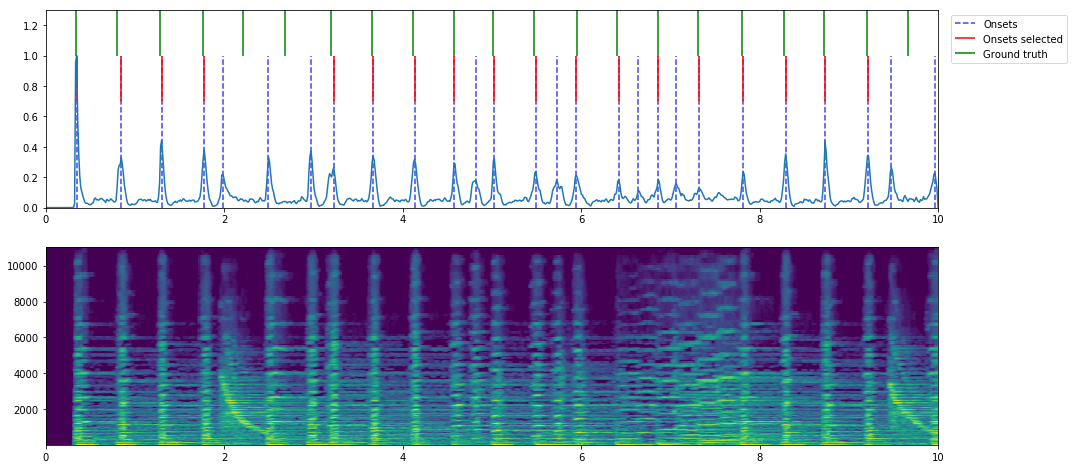

In [6]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
audiobeats = dataset[i]
beatfinder.display.showdata(audiobeats)

F measure: 0.93


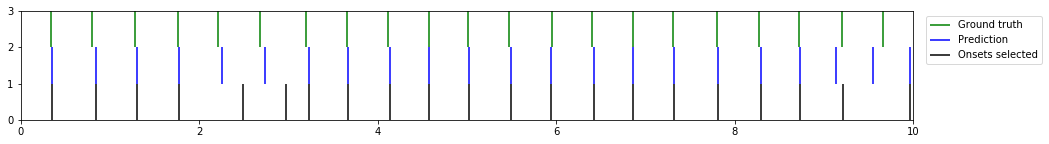

In [7]:
onsets_selected, beats_pred, bpm = beatfinder.utils.predict_beats(model, audiobeats, totensor)
beats = audiobeats.get_beats()
beatfinder.display.showprediction(beats, beats_pred, onsets_selected)
F = beatfinder.utils.F_measure(beats, beats_pred)
if F != None:
    print(f'F measure: {F:.2f}')
else:
    print('F measure: NaN')

# Evaluate a dataset

In [10]:
F_model, F_model_nan, F_libro, F_libro_nan = beatfinder.utils.F_measure_with_librosa_comparison(model, 
                                                                                                dataset, 
                                                                                                totensor)
print()
print(f'model F measure: {F_model:.3f}')
print(f'     model NaNs: {F_model_nan}')
print(f'libro F measure: {F_libro:.3f}')
print(f'     libro NaNs: {F_libro_nan}')

  0 |   NaN  0.600
  1 | 0.500  0.488
  2 | 0.353  0.634
  3 |   NaN   NaN 
  4 |   NaN   NaN 
  5 | 0.963  0.632
  6 | 0.941  0.479
  7 | 1.000  0.981
  8 | 0.889  0.981
  9 | 0.609  0.889
 10 | 0.985  0.985
 11 | 0.475  0.909
 12 | 1.000  0.656
 13 | 1.000  0.656
 14 | 1.000  0.644
 15 | 0.837  0.656
 16 | 0.976  0.645
 17 | 0.927  0.667
 18 | 0.537  0.486
 19 | 0.821  0.562
 20 | 0.983  0.966
 21 | 0.889  0.444
 22 | 0.786  0.327
 23 | 1.000  0.667
 24 | 0.381  0.656
 25 | 0.976  0.667
 26 | 1.000  0.656
 27 | 1.000  0.983
 28 | 1.000  0.947
 29 | 0.983  0.966
 30 | 0.974  0.644
 31 | 1.000  0.656
 32 | 0.976  0.667
 33 | 1.000  0.680
 34 | 1.000  0.653
 35 | 1.000  0.667
 36 | 0.105  0.226
 37 | 0.385  0.339
 38 | 0.500  0.321
 39 | 0.286  0.667
 40 | 0.848  0.680
 41 | 0.308  0.680
 42 | 0.976  0.623
 43 | 0.976  0.667
 44 | 1.000  0.656
 45 | 0.381  0.964
 46 | 0.667  0.881
 47 | 0.605  0.906
 48 | 0.974  0.655
 49 | 1.000  0.655
 50 | 1.000  0.655
 51 | 0.279  0.636
 52 | 0.844 

In [30]:
# model 11
F, F_nan = beatfinder.utils.F_measure_from_dataset(model, dataset, totensor)
print()
print(f'F measure: {F:.2f}')
print(f'     NaNs: {F_nan}')

  0 :  NaN |   1 : 0.50 |   2 : 0.35 |   3 :  NaN |   4 :  NaN |   5 : 0.96 |   6 : 0.94 |   7 : 1.00 | 
  8 : 0.89 |   9 : 0.61 |  10 : 0.99 |  11 : 0.47 |  12 : 1.00 |  13 : 1.00 |  14 : 1.00 |  15 : 0.84 | 
 16 : 0.98 |  17 : 0.93 |  18 : 0.54 |  19 : 0.82 |  20 : 0.98 |  21 : 0.89 |  22 : 0.79 |  23 : 1.00 | 
 24 : 0.38 |  25 : 0.98 |  26 : 1.00 |  27 : 1.00 |  28 : 1.00 |  29 : 0.98 |  30 : 0.97 |  31 : 1.00 | 
 32 : 0.98 |  33 : 1.00 |  34 : 1.00 |  35 : 1.00 |  36 : 0.11 |  37 : 0.38 |  38 : 0.50 |  39 : 0.29 | 
 40 : 0.85 |  41 : 0.31 |  42 : 0.98 |  43 : 0.98 |  44 : 1.00 |  45 : 0.38 |  46 : 0.67 |  47 : 0.60 | 
 48 : 0.97 |  49 : 1.00 |  50 : 1.00 |  51 : 0.28 |  52 : 0.84 |  53 : 1.00 |  54 : 1.00 |  55 : 0.37 | 
 56 : 1.00 |  57 : 1.00 |  58 : 1.00 |  59 : 1.00 |  60 : 0.93 |  61 : 1.00 |  62 : 0.97 |  63 : 0.38 | 
 64 : 0.97 |  65 : 0.35 |  66 : 0.97 |  67 : 1.00 |  68 : 0.97 |  69 : 0.25 |  70 : 0.67 |  71 : 0.65 | 
 72 : 0.55 |  73 : 0.55 |  74 : 0.74 |  75 : 0.87 |  76

In [27]:
F, F_nan = beatfinder.utils.F_measure_from_dataset(model, dataset, totensor)
print()
print(f'F measure: {F:.2f}')
print(f'     NaNs: {F_nan}')

  0 :  NaN |   1 : 0.38 |   2 : 0.34 |   3 :  NaN |   4 :  NaN |   5 : 0.96 |   6 : 0.94 |   7 : 0.95 | 
  8 : 0.91 |   9 : 0.61 |  10 : 0.67 |  11 : 0.67 |  12 : 1.00 |  13 : 1.00 |  14 : 1.00 |  15 : 0.86 | 
 16 : 1.00 |  17 : 1.00 |  18 : 0.52 |  19 : 0.95 |  20 : 0.98 |  21 : 0.93 |  22 : 0.86 |  23 : 0.83 | 
 24 : 0.38 |  25 : 0.93 |  26 : 1.00 |  27 : 1.00 |  28 : 1.00 |  29 : 0.98 |  30 : 0.97 |  31 : 1.00 | 
 32 : 0.81 |  33 : 1.00 |  34 : 1.00 |  35 : 1.00 |  36 : 0.73 |  37 : 0.73 |  38 : 0.64 |  39 : 0.31 | 
 40 : 0.38 |  41 : 0.86 |  42 : 0.98 |  43 : 0.98 |  44 : 1.00 |  45 : 0.65 |  46 : 0.67 |  47 : 0.60 | 
 48 : 0.92 |  49 : 1.00 |  50 : 1.00 |  51 : 0.31 |  52 : 0.84 |  53 : 1.00 |  54 : 1.00 |  55 : 0.30 | 
 56 : 1.00 |  57 : 1.00 |  58 : 1.00 |  59 : 1.00 |  60 : 0.95 |  61 : 1.00 |  62 : 1.00 |  63 : 0.35 | 
 64 : 0.97 |  65 : 0.46 |  66 : 0.84 |  67 : 0.75 |  68 : 0.47 |  69 : 0.27 |  70 : 0.67 |  71 : 0.58 | 
 72 : 0.31 |  73 : 0.93 |  74 : 0.83 |  75 : 0.87 |  76